<img src='images/cin-logo.png' style='width:600px;'>

# IF997- TÓPICOS AVANÇADOS EM SI 1
## Projeto Incognia

### Grupo: Alisson Diego, Guilherme Santiago, Pedro Sena

## Base de Dados

| coluna                               | tipo   | descrição                                                                                     |
|--------------------------------------|--------|-----------------------------------------------------------------------------------------------|
| id                                   | string | identificador do login                                                                        |
| account_id                           | string | identificador da conta                                                                        |
| device_id                            | string | identificador do dispositivo                                                                  |
| installation_id                      | string | identificador da instalação                                                                   |
| timestamp                            | long   | timestamp (unixtime - em ms)                                                                  |
| is_from_official_store               | bool   | se o app utilizado foi instalado através de uma loja oficial                                  |
| is_emulator                          | bool   | uso de emulador                                                                               |
| has_fake_location_app                | bool   | se o dispositivo possui aplicação de geração localizações falsas                              |
| has_fake_location_enable             | bool   | se o dispositivo habilitou geração de localizações falsas                                     |
| probable_root                        | bool   | provável root do sistema                                                                      |
| device_age_ms                        | long   | idade do dispositivo (em ms)                                                                  |
| max_installations_on_related_devices | int    | quantidade máxima de instalações dos dispositivos associados à conta                          |
| never_permited_location_on_account   | bool   | se o dispositivo nunca habilitou coleta de localizações, quando outros dispositivos o fizeram |
| boot_count                           | int    | quantidade de reinicializações do dispositivo                                                 |
| wallpaper_count                      | int    | quantidade de wallpapers do dispositivo                                                       |
| n_accounts                           | int    | número de contas acessadas pelo dispositivo                                                   |
| ato                                  | bool   | se login está associado a um evento de account takeover                                       |

## Bibliotecas utilizadas

- Tratamento de dados
  - datetime
  - numpy
  - pandas
- Gráficos
  - matplotlib
  - sklearn


In [423]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn import linear_model

%matplotlib inline
plt.style.use('seaborn')

## 1. Pré processamento

In [424]:
logins_df = pd.read_parquet('./dataset/logins.parquet4')
print(logins_df.info())
logins_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5418786 entries, 0 to 5418785
Data columns (total 17 columns):
 #   Column                                Dtype  
---  ------                                -----  
 0   id                                    object 
 1   account_id                            object 
 2   device_id                             object 
 3   installation_id                       object 
 4   timestamp                             float64
 5   is_from_official_store                float64
 6   is_emulator                           float64
 7   has_fake_location_app                 float64
 8   has_fake_location_enabled             float64
 9   probable_root                         float64
 10  device_age_ms                         float64
 11  max_installations_on_related_devices  float64
 12  never_permitted_location_on_account   float64
 13  boot_count                            float64
 14  wallpaper_count                       float64
 15  n_accounts     

,id,account_id,device_id,installation_id,timestamp,is_from_official_store,is_emulator,has_fake_location_app,has_fake_location_enabled,probable_root,device_age_ms,max_installations_on_related_devices,never_permitted_location_on_account,boot_count,wallpaper_count,n_accounts,ato
0,799740346458,YgXAhVgdDLsozwto,fGb574abkmDJTQ6M,Uv9PEQZEwsW8nLOj,1.621290e+12,1.0,0.0,0.0,0.0,0.0,1.407468e+09,1.0,0.0,129.0,28.0,1.0,0.0
1,799740346459,bO+gPxgfZG9sXtCb,Xll03k9l/OL2r6LM,pR7skP90RuM3oqhK,1.620309e+12,1.0,0.0,0.0,0.0,0.0,1.622747e+10,2.0,0.0,131.0,224.0,1.0,0.0
2,799740346460,9mEBGcdz+RLzRNB4,qoKjqPhxqyALMsQ5,hzKrODiR6F0jG4rH,1.625228e+12,1.0,0.0,0.0,0.0,0.0,2.865500e+10,2.0,0.0,179.0,6.0,1.0,0.0
3,799740346461,tghz/Mlz069esl03,5fqsAP5QUp1M3PLC,krWwUuXbmBEP9g38,1.624645e+12,1.0,0.0,0.0,0.0,0.0,2.484419e+10,3.0,0.0,38.0,11.0,1.0,0.0
4,799740346462,9mEBGcdz+RLzRNB4,qoKjqPhxqyALMsQ5,hzKrODiR6F0jG4rH,1.619907e+12,1.0,0.0,0.0,0.0,0.0,2.334158e+10,2.0,0.0,NaN,NaN,1.0,0.0


### 1.1 Remover linhas nulas

In [425]:
lista_colunas = ['id', 'account_id', 'device_id', 'installation_id']
null_ids = np.where(logins_df[lista_colunas].isnull())[0]

lista_id = []
for id in null_ids:
  if id not in lista_id:
    lista_id.append(id)

logins_df.drop(inplace=True, index=lista_id)

null_n_accounts = logins_df[logins_df['n_accounts'].isnull()]
logins_df.drop(index=null_n_accounts.index, inplace=True)

### 1.2 Remover colunas

In [426]:
logins_df.drop('wallpaper_count', axis=1, inplace=True)
logins_df.drop('boot_count', axis=1, inplace=True)

### 1.3 Preencher valores nulos

In [427]:
moda_timestamp = logins_df['timestamp'].mode()[0]
moda_device_age = logins_df['device_age_ms'].mode()[0]
lista_colunas = [ 
  'never_permitted_location_on_account', 
  'max_installations_on_related_devices', 
  'is_from_official_store', 
  'is_emulator', 
  'has_fake_location_app', 
  'has_fake_location_enabled', 
  'probable_root', 
  'max_installations_on_related_devices', 
  'has_fake_location_enabled',
  'probable_root',
  'is_from_official_store',
  'never_permitted_location_on_account',
]

logins_df['timestamp'] = logins_df['timestamp'].fillna(moda_timestamp)
logins_df['device_age_ms'] = logins_df['device_age_ms'].fillna(moda_device_age)

for coluna in lista_colunas:
  logins_df[coluna] = logins_df[coluna].fillna(0)

### 1.4 Conversão de tipos

In [428]:
lista_colunas = [*lista_colunas, 'n_accounts', 'ato']
logins_df[lista_colunas] = logins_df[lista_colunas].astype('int32')
contas = len(logins_df['account_id'].unique())
dispostivos = len(logins_df['device_id'].unique())
tentativas_ato = logins_df[logins_df['ato'] == 1].count()

print ('Acessos:', logins_df.shape[0])
print ('Contas:', contas)
print('Dispositivos:', dispostivos)
print('Tentativas de ATO:', tentativas_ato['ato'])
print('---------------------------------------')
print(logins_df.info())
logins_df.head()

Acessos: 5162049
Contas: 305889
Dispositivos: 364675
Tentativas de ATO: 2019
---------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5162049 entries, 0 to 5418785
Data columns (total 15 columns):
 #   Column                                Dtype  
---  ------                                -----  
 0   id                                    object 
 1   account_id                            object 
 2   device_id                             object 
 3   installation_id                       object 
 4   timestamp                             float64
 5   is_from_official_store                int32  
 6   is_emulator                           int32  
 7   has_fake_location_app                 int32  
 8   has_fake_location_enabled             int32  
 9   probable_root                         int32  
 10  device_age_ms                         float64
 11  max_installations_on_related_devices  int32  
 12  never_permitted_location_on_account   int32  
 13  

,id,account_id,device_id,installation_id,timestamp,is_from_official_store,is_emulator,has_fake_location_app,has_fake_location_enabled,probable_root,device_age_ms,max_installations_on_related_devices,never_permitted_location_on_account,n_accounts,ato
0,799740346458,YgXAhVgdDLsozwto,fGb574abkmDJTQ6M,Uv9PEQZEwsW8nLOj,1.621290e+12,1,0,0,0,0,1.407468e+09,1,0,1,0
1,799740346459,bO+gPxgfZG9sXtCb,Xll03k9l/OL2r6LM,pR7skP90RuM3oqhK,1.620309e+12,1,0,0,0,0,1.622747e+10,2,0,1,0
2,799740346460,9mEBGcdz+RLzRNB4,qoKjqPhxqyALMsQ5,hzKrODiR6F0jG4rH,1.625228e+12,1,0,0,0,0,2.865500e+10,2,0,1,0
3,799740346461,tghz/Mlz069esl03,5fqsAP5QUp1M3PLC,krWwUuXbmBEP9g38,1.624645e+12,1,0,0,0,0,2.484419e+10,3,0,1,0
4,799740346462,9mEBGcdz+RLzRNB4,qoKjqPhxqyALMsQ5,hzKrODiR6F0jG4rH,1.619907e+12,1,0,0,0,0,2.334158e+10,2,0,1,0


## 2. Criar novos dados

### 2.1 Funções auxiliares

In [429]:
def converteData(timestamp_ms):
  timestamp_sec = timestamp_ms / 1000
  data = datetime.fromtimestamp(timestamp_sec)
  return data

def converteIdade(idade_ms):
  idade_sec = idade_ms / 1000
  return int(idade_sec / 86400)

def adicionaColunaAtoComRoot(linha):
  if linha['probable_root'] == 1 and linha['ato'] == 1:
    return 1
  return 0

def adicionaColunaLojaAto(linha):
  if linha['is_from_official_store'] == 1 and linha['ato'] == 1:
    return 1
  return 0

def adicionaColunaEmuladorIdadeDispositivo(linha):
  if linha['is_emulator'] == 1 and linha['device_age_days'] > 365:
    return 1
  return 0

def diaDaSemana(data):
  dias = {0: "Segunda", 1: "Terça", 2: "Quarta", 3: "Quinta", 4: "Sexta", 5: "Sábado", 6: "Domingo"}
  return dias[data.dayofweek]

### 2.2 Dataframe das contas

| coluna        | tipo   | descricao                                |
|---------------|--------|------------------------------------------|
| account_id    | string | id da conta                              |
| n_logins      | int    | total de logins da conta                 |
| total_ato     | int    | total de ATOs na conta                   |
| n_devices     | int    | total de dispositivos associados a conta |
| ato_per_login | float  | relação entre os ATOs e os logins        |

In [430]:
contas = logins_df.groupby('account_id')
logins = contas.size().reset_index(name='n_logins')
ato = logins_df[logins_df['ato'] == 1].groupby('account_id')['ato'].size().reset_index(name='total_ato')
dispositivos = logins_df.groupby('account_id')['device_id'].nunique().reset_index(name='n_devices')

contas_df = pd.merge(logins, ato, on='account_id', how='inner')
contas_df = pd.merge(contas_df, dispositivos, on='account_id', how='inner')
contas_df['ato_per_login'] = contas_df['total_ato'] / contas_df['n_logins']
contas_df.describe()

,n_logins,total_ato,n_devices,ato_per_login
count,331.000000,331.000000,331.000000,331.000000
mean,19.963746,6.099698,1.854985,0.612066
std,36.746369,11.299465,0.951935,0.387036
min,1.000000,1.000000,1.000000,0.005556
25%,2.000000,1.000000,1.000000,0.237647
50%,6.000000,2.000000,2.000000,0.666667
75%,20.000000,6.000000,2.000000,1.000000
max,343.000000,107.000000,10.000000,1.000000


### 2.3 Dataframe com datas dos acessos

| coluna       | tipo     | descricao                                  |
|--------------|----------|--------------------------------------------|
| dates        | datetime | datas dos logins                           |
| n_logins     | int      | total de logins nessa data                 |
| total_ato    | int      | total de ATOs na data                      |
| login_SMA_15 | float    | média móvel de 15 dias do login            |
| login_CMA    | float    | média móvel acumulada do login             |
| login_CMA    | float    | média móvel acumulada do login             | 
| ato_EMA_0.3  | float    | média móvel exponencial dos logins (α=0.3) |
| ato_SMA_15   | float    | média móvel de 15 dias do ato              |
| ato_CMA      | float    | média móvel acumulada do ato               |
| ato_EMA_0.3  | float    | média móvel exponencial dos ATOs (α=0.3)   |

In [431]:
# logins_df['timestamp'] = logins_df['timestamp'].apply(converteData)
# logins_df['dates'] = logins_df['timestamp'].apply(lambda x: x.date())

data_acessos_df = logins_df.groupby('dates')['id'].size().reset_index(name='n_logins')
ato = logins_df[logins_df['ato'] == 1].groupby('dates').size().reset_index(name='total_ato')
data_acessos_df = pd.merge(data_acessos_df, ato, on='dates')
data_acessos_df.set_index('dates', inplace=True)

data_acessos_df['login_SMA_15'] =  data_acessos_df.n_logins.rolling(15, min_periods=1).mean()
data_acessos_df['login_CMA'] =  data_acessos_df.n_logins.expanding().mean()
data_acessos_df['login_EMA_0.3'] =  data_acessos_df.n_logins.ewm(alpha=0.3, adjust=False).mean()

data_acessos_df['ato_SMA_15'] =  data_acessos_df.total_ato.rolling(15, min_periods=1).mean()
data_acessos_df['ato_CMA'] =  data_acessos_df.total_ato.expanding().mean()
data_acessos_df['ato_EMA_0.3'] =  data_acessos_df.total_ato.ewm(alpha=0.3, adjust=False).mean()

data_acessos_df

KeyError: 'dates'

In [ ]:
#Novas colunas
logins_df['device_age_ms'] = logins_df['device_age_ms'].apply(converteIdade)
logins_df.rename(columns={'device_age_ms': 'device_age_days'}, inplace=True)

logins_df['day_of_week'] = logins_df['timestamp'].apply(lambda x: diaDaSemana(x))
logins_df['probable_root_ato'] = logins_df.apply(lambda x: adicionaColunaAtoComRoot(x), axis=1)
logins_df['is_from_official_store_ato'] = logins_df.apply(lambda x: adicionaColunaLojaAto(x), axis=1)

logins_df.head()

,id,account_id,device_id,installation_id,timestamp,is_from_official_store,is_emulator,has_fake_location_app,has_fake_location_enabled,probable_root,device_age_days,max_installations_on_related_devices,never_permitted_location_on_account,n_accounts,ato,dates,day_of_week,probable_root_ato,is_from_official_store_ato
0,799740346458,YgXAhVgdDLsozwto,fGb574abkmDJTQ6M,Uv9PEQZEwsW8nLOj,2021-05-17 19:25:37.164,1,0,0,0,0,16,1,0,1,0,2021-05-17,Segunda,0,0
1,799740346459,bO+gPxgfZG9sXtCb,Xll03k9l/OL2r6LM,pR7skP90RuM3oqhK,2021-05-06 10:48:57.125,1,0,0,0,0,187,2,0,1,0,2021-05-06,Quinta,0,0
2,799740346460,9mEBGcdz+RLzRNB4,qoKjqPhxqyALMsQ5,hzKrODiR6F0jG4rH,2021-07-02 09:11:39.844,1,0,0,0,0,331,2,0,1,0,2021-07-02,Sexta,0,0
3,799740346461,tghz/Mlz069esl03,5fqsAP5QUp1M3PLC,krWwUuXbmBEP9g38,2021-06-25 15:24:27.436,1,0,0,0,0,287,3,0,1,0,2021-06-25,Sexta,0,0
4,799740346462,9mEBGcdz+RLzRNB4,qoKjqPhxqyALMsQ5,hzKrODiR6F0jG4rH,2021-05-01 19:02:04.663,1,0,0,0,0,270,2,0,1,0,2021-05-01,Sábado,0,0


### Salvando os Dataframes

In [ ]:
logins_df.to_parquet("./dataset/new_logins.parquet4")
contas_df.to_parquet("./dataset/contas.parquet4")
data_acessos_df.to_parquet("./dataset/acessos_por_data.parquet4")

## 3. Perguntas

1. Qual a porcentagem de ATOs ocorridos?

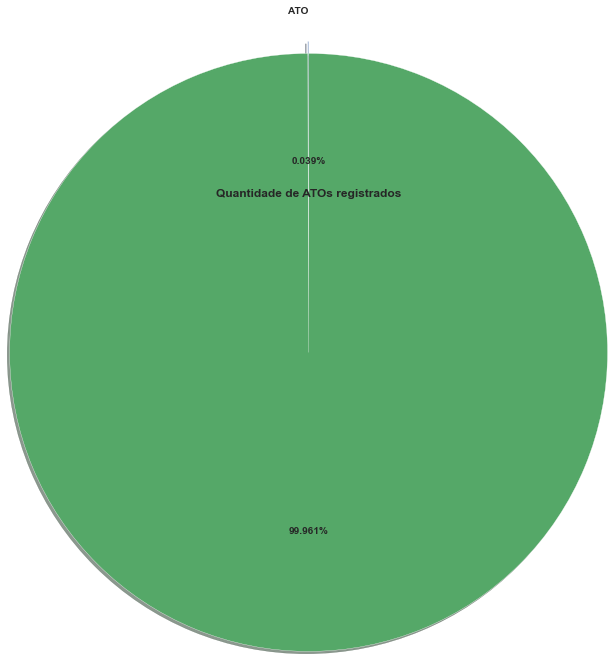

In [ ]:
ato = logins_df[logins_df['ato'] == 1].count()[0]
not_ato = logins_df[logins_df['ato'] == 0].count()[0]

plt.pie([ato, not_ato], shadow=True, startangle=90, explode=[0.1,0], labels=['ATO', ''], autopct='%1.3f%%', radius=2.5)
plt.title('Quantidade de ATOs registrados')
plt.show()

2. Qual a relação entre login e ATO?

Média de ATOs por login: 0.6120658138119714


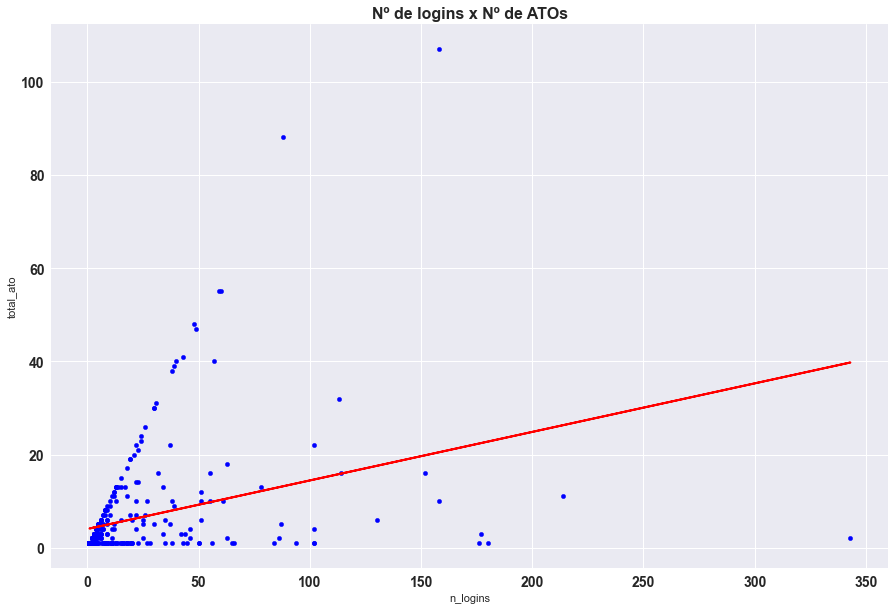

In [ ]:
tamanho = contas_df.shape[0]
x = contas_df['n_logins'].values
y = contas_df['total_ato'].values

x = x.reshape(tamanho, 1)
y = y.reshape(tamanho, 1)

regr = linear_model.LinearRegression()
regr.fit(x, y)

contas_df.plot(kind='scatter', x='n_logins', y='total_ato', color='blue', figsize=(15, 10))
plt.plot(x, regr.predict(x), color='red', linewidth=2)
plt.title('Nº de logins x Nº de ATOs', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
print('Média de ATOs por login:', contas_df['ato_per_login'].mean())
plt.show()


3. Qual o dia da semana que tem mais acessos?

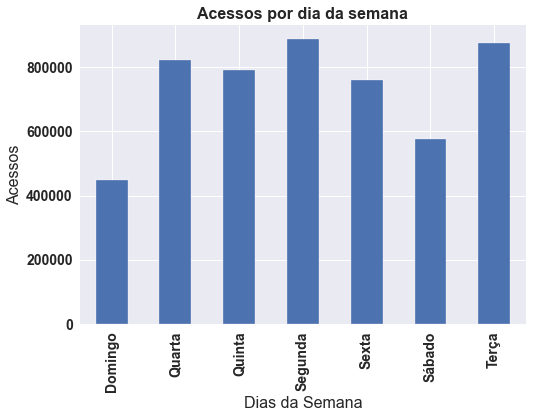

In [ ]:
logins_df.groupby('day_of_week').size().plot(kind='bar')
plt.title('Acessos por dia da semana', fontsize=16)
plt.xlabel('Dias da Semana', fontsize=16)
plt.ylabel('Acessos', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

4. Qual foi o comportamento dos da quantidade de acessos pelo tempo?

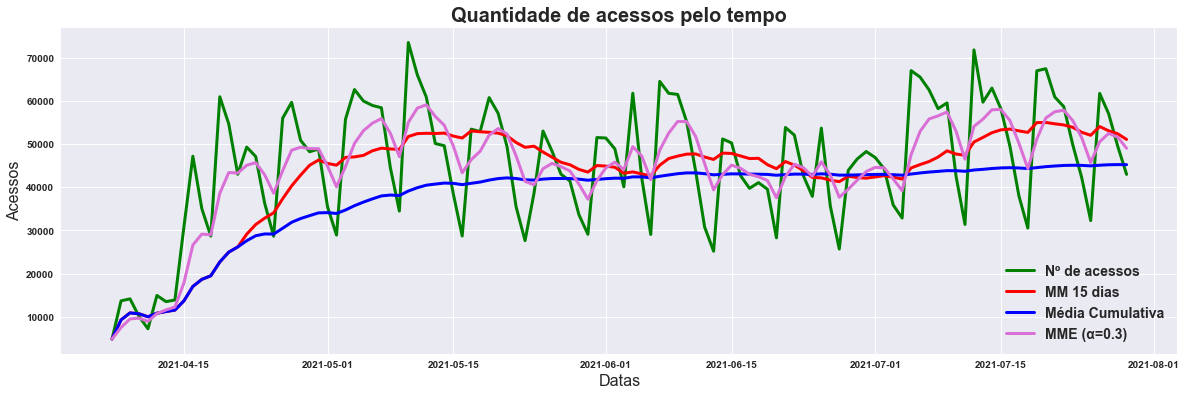

In [ ]:
cores = ['green', 'red', 'blue', 'orchid']
data_acessos_df[['n_logins', 'login_SMA_15', 'login_CMA', 'login_EMA_0.3']].plot(color=cores, linewidth=3, figsize=(20, 6))
plt.legend(labels =['Nº de acessos', 'MM 15 dias', 'Média Cumulativa', 'MME (α=0.3)'], fontsize=14)
plt.title('Quantidade de acessos pelo tempo', fontsize=20)
plt.xlabel('Datas', fontsize=16)
plt.ylabel('Acessos', fontsize=16)
plt.show()

5. Existem ATOs que não foram de instalações de lojas oficiais?

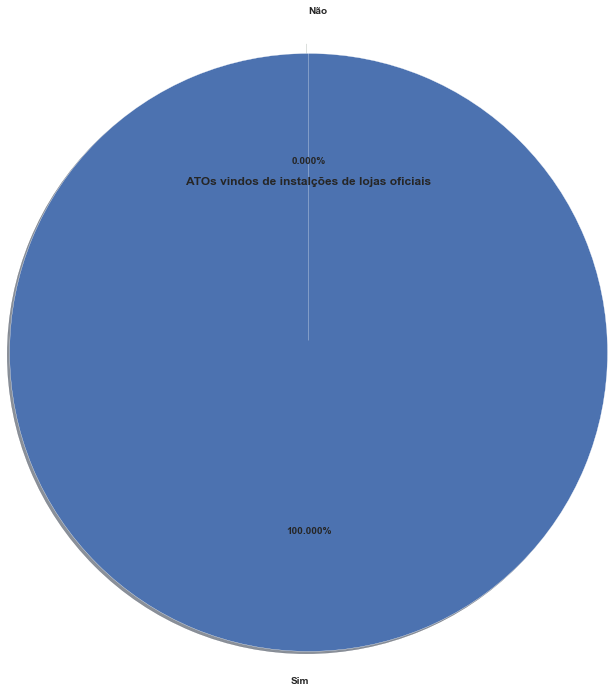

In [ ]:
logins_ato = logins_df[logins_df['ato'] == 1]
total_ato = logins_ato.shape[0]

sim = logins_ato[logins_ato['is_from_official_store_ato'] == 1].count()[0]
nao = total_ato - sim

plt.pie([sim, nao], shadow=True, startangle=90, explode=[0.1,0], labels=['Sim', 'Não'], autopct='%1.3f%%', radius=2.5)
plt.title('ATOs vindos de instalções de lojas oficiais')
plt.show()

6. Qual a porcentagem de ATOs em contas com mais de um dispositivo?

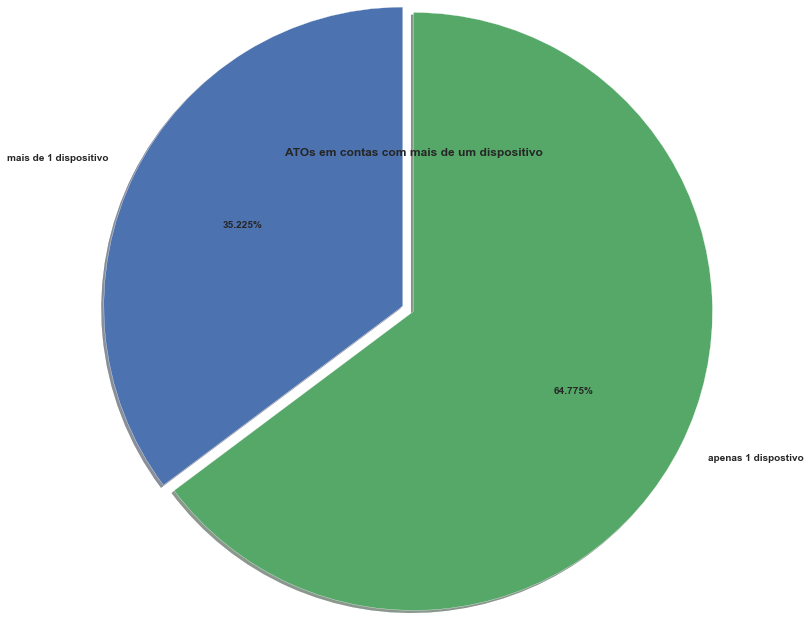

In [ ]:
ato_n_dispositivos = logins_ato.groupby('account_id')['device_id'].size() > 1
valores = np.zeros(2)
for valor in ato_n_dispositivos.values:
  if valor:
    valores[0] += 1
  valores[1] += 1

plt.pie(valores, shadow=True, startangle=90, explode=[0.1,0], labels=['mais de 1 dispositivo', 'apenas 1 dispostivo'], autopct='%1.3f%%', radius=2.5)
plt.title('ATOs em contas com mais de um dispositivo')
plt.show()

7. Qual a quantidade de ATOs que foram de usuários root?

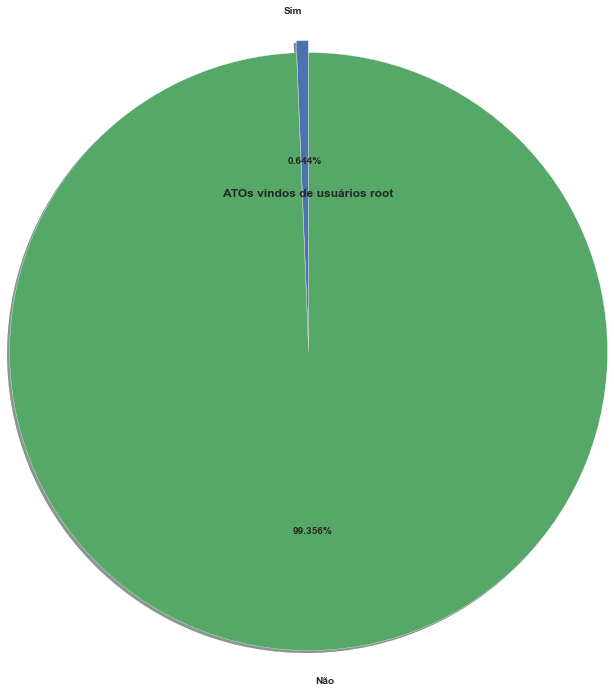

In [ ]:
sim = logins_ato[logins_ato['probable_root_ato'] == 1].count()[0]
nao = total_ato - sim

plt.pie([sim, nao], shadow=True, startangle=90, explode=[0.1,0], labels=['Sim', 'Não'], autopct='%1.3f%%', radius=2.5)
plt.title('ATOs vindos de usuários root')
plt.show()

8. Qual é a tendencia dos ATOs?

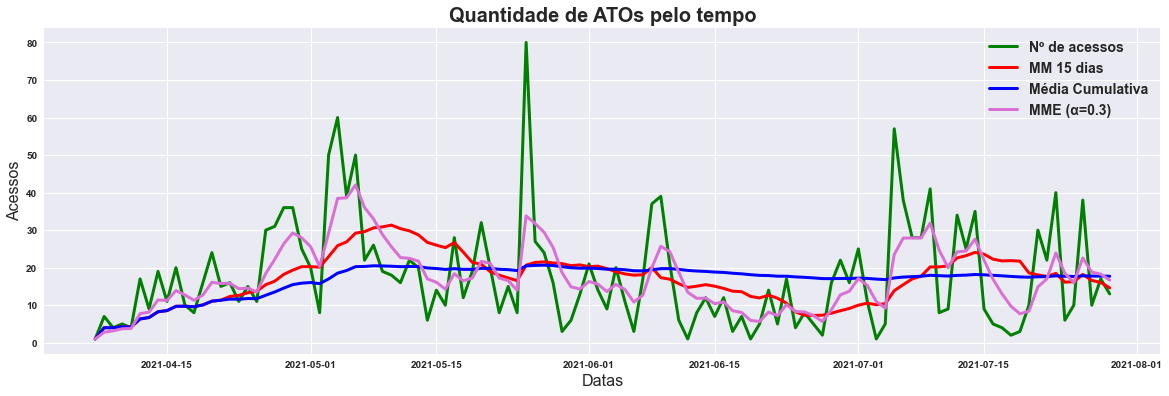

In [ ]:
data_acessos_df[['total_ato', 'ato_SMA_15', 'ato_CMA', 'ato_EMA_0.3']].plot(color=cores, linewidth=3, figsize=(20, 6))
plt.legend(labels =['Nº de acessos', 'MM 15 dias', 'Média Cumulativa', 'MME (α=0.3)'], fontsize=14)
plt.title('Quantidade de ATOs pelo tempo', fontsize=20)
plt.xlabel('Datas', fontsize=16)
plt.ylabel('Acessos', fontsize=16)
plt.show()

9. Existem ATOs em dispositivos que nunca permitiram a localização na conta?

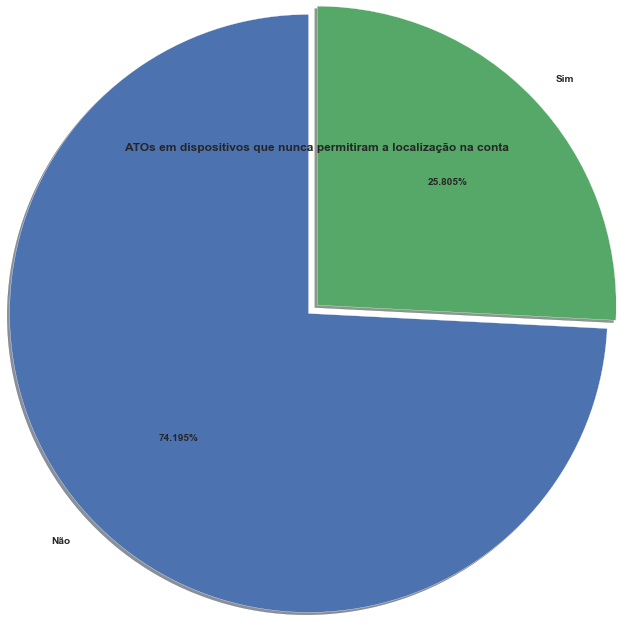

In [ ]:
sim = logins_ato[logins_ato['never_permitted_location_on_account'] == 1].count()[0]
nao = logins_ato.shape[0] - sim

plt.pie([nao, sim], shadow=True, startangle=90, explode=[0.1,0], labels=['Não', 'Sim'], autopct='%1.3f%%', radius=2.5)
plt.title('ATOs em dispositivos que nunca permitiram a localização na conta')
plt.show()

10. Existem ATOs em dispositivos com aplicativo de localização falsa?

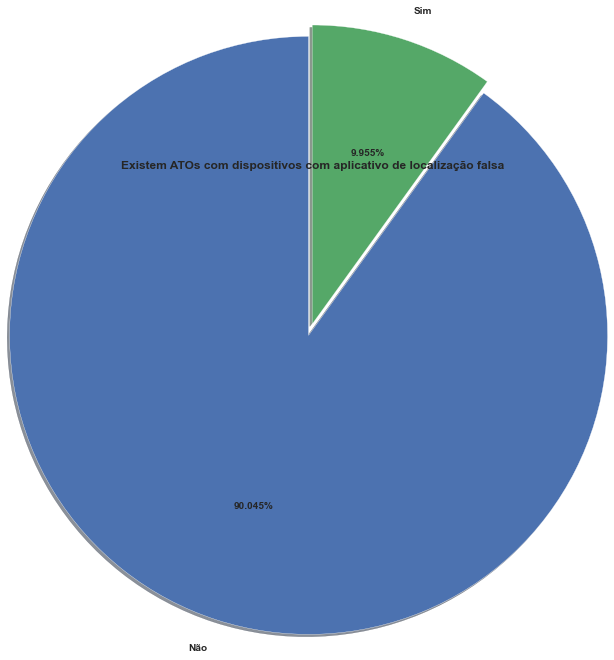

In [ ]:
sim = logins_ato[logins_ato['has_fake_location_app'] == 1].count()[0]
nao = total_ato - sim

plt.pie([nao, sim], shadow=True, startangle=90, explode=[0.1,0], labels=['Não', 'Sim'], autopct='%1.3f%%', radius=2.5)
plt.title('Existem ATOs com dispositivos com aplicativo de localização falsa')
plt.show()